In [3]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(2, 4)
(101,)
(2, 101)


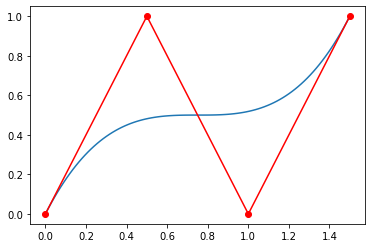

In [4]:
import bezier

nodes = np.asfortranarray([
    [0.0, 0.5, 1.0, 1.5],
    [0.0, 1.0, 0.0, 1.0],
])

print(nodes.shape)
curve = bezier.Curve(nodes, degree=3)

# Evaluate the curve at 101 points.
t = np.linspace(0.0, 1.0, 101)
print(t.shape)
evaluated = curve.evaluate_multi(t)


print(evaluated.shape)

# Plot the evaluated curve.
plt.plot(evaluated[0], evaluated[1])
plt.plot(nodes[0], nodes[1], "ro-")

plt.show()


(100, 2)
(7, 2)


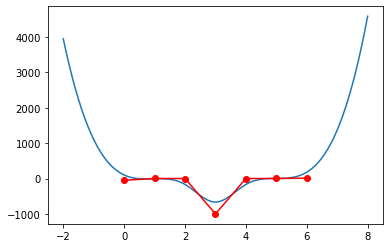

In [5]:
# Create a B-spline of Degree 3
k = 3
t = [0, 1, 2, 3, 4, 5, 6, 7, 8,9,10]
c = [[0,-50],
        [1,1],
        [2,0],
        [3,-1000],
        [4,0],
        [5,1],
        [6,10]
     ]
spl = BSpline(t, c, k)

# Evaluate the B-spline

x = np.linspace(0, 10, 100)
y = spl(x)

print(y.shape)

print(np.array(c).shape)
# Plot the B-spline
plt.plot(y[:,0], y[:,1])
# Plot the control points

c = np.array(c) 
plt.plot(c[:,0], c[:,1], "ro-")



plt.show()


In [6]:
# Define B-spline basis functions
def bspline_basis(t, i, k, knots):
    if k == 0:
        return 1.0 if knots[i] <= t < knots[i+1] else 0.0
    else:
        denom1 = knots[i+k] - knots[i]
        if denom1 == 0.0:
            term1 = 0.0
        else:
            term1 = 0.0 if denom1 == 0.0 else (t - knots[i]) / denom1 * bspline_basis(t, i, k-1, knots)
        denom2 = knots[i+k+1] - knots[i+1]
        if denom2 == 0.0:
            term2 = 0.0
        else:
            term2 = 0.0 if denom2 == 0.0 else (knots[i+k+1] - t) / denom2 * bspline_basis(t, i+1, k-1, knots)
        return term1 + term2

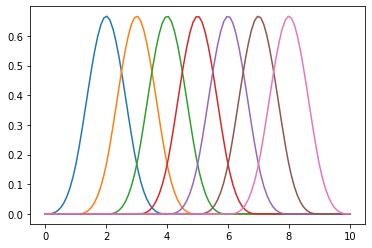

In [7]:
t = np.linspace(0, 10, 100)
knots = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
basis0 = np.array([bspline_basis(t_, 0, 3, knots) for t_ in t]).reshape(100)
basis1 = np.array([bspline_basis(t_, 1, 3, knots) for t_ in t]).reshape(100)
basis2 = np.array([bspline_basis(t_, 2, 3, knots) for t_ in t]).reshape(100)
basis3 = np.array([bspline_basis(t_, 3, 3, knots) for t_ in t]).reshape(100)
basis4 = np.array([bspline_basis(t_, 4, 3, knots) for t_ in t]).reshape(100)
basis5 = np.array([bspline_basis(t_, 5, 3, knots) for t_ in t]).reshape(100)
basis6 = np.array([bspline_basis(t_, 6, 3, knots) for t_ in t]).reshape(100)



plt.plot(t, basis0, label="Basis 0")
plt.plot(t, basis1, label="Basis 1")
plt.plot(t, basis2, label="Basis 2")
plt.plot(t, basis3, label="Basis 3")
plt.plot(t, basis4, label="Basis 4")
plt.plot(t, basis5, label="Basis 5")
plt.plot(t, basis6, label="Basis 6")

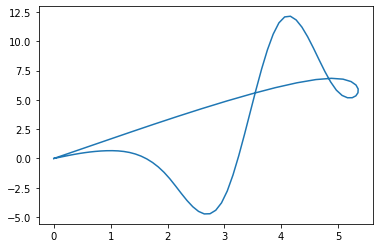

In [8]:
# casssssssssssslculate the B-spline curve
curve = np.zeros((len(t), 2))


c = np.array([[0,0],
        [1,1],
        [2,0],
        [3,-10],
        [4,20],
        [5,1],
        [6,10]    
    ])
for j, t_ in enumerate(t):
    for i in range(7):
        curve[j] += bspline_basis(t_, i, 3, knots) * c[i]   

plt.plot(curve[:-1,0], curve[:-1,1], label="B-spline curve")


11
11
Total number of variables............................:       14
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   1.1368683772161603e-13    1.1368683772161603e-13
Constraint violation....:   1.9989999999000000e+02    1.9989999999000000e+02
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Compleme

ValueError: could not broadcast input array from shape (2,1) into shape (2,)

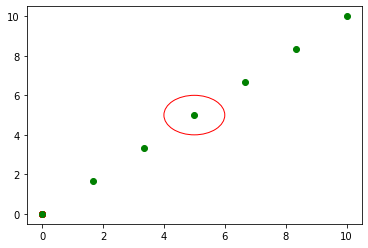

In [18]:
#B-spline basis function as casssssadi symbolic expression

# Assumptioms: Knots are equally spaced and constant for this optimization problem, They are defined in such a way that the B-spline is closed
# The control points are the decision variables


import casadi as cas


def bspline_basis(t, i, k, knots):
    if k == 0:
        return cas.if_else(cas.le(t, knots[i+1]), 1.0, 0.0)
    else:
        denom1 = knots[i+k] - knots[i]
        if denom1 == 0.0:
            term1 = 0.0
        else:
            term1 = ((t - knots[i]) / denom1) * bspline_basis(t, i, k-1, knots)

        denom2 = knots[i+k+1] - knots[i+1]
        if denom2 == 0.0:
            term2 = 0.0
        else:
            term2 = ((knots[i+k+1] - t) / denom2) * bspline_basis(t, i+1, k-1, knots)

        return term1 + term2


def bspline(t, c, k, knots):
    curve_sample = cas.SX.zeros(2)
    for i in range(n_control_points):
        curve_sample = curve_sample + bspline_basis(t, i, k, knots) * c[i]
    return curve_sample

# Define Optimization problem

n_spline_points = 100
n_control_points = 7   
deg_spline = 3

n_knots = n_control_points + deg_spline + 1

knots = [0, 1, 2, 3, 4, 5, 6, 7, 8,9,10]
print(len(knots))
print(n_knots)

assert len(knots) == n_knots

control_points = cas.SX.sym("control_points", n_control_points, 2)

dec_vars = cas.vertcat(cas.vec(control_points))

# Define constraints
start_point = np.array([0, 0])
end_point = np.array([10, 10])

cons = cas.SX([])
lbg = []
ubg = []





# Define Path constraints on spline curve
obstacle_position = np.array([5, 5])
obstacle_radius = 1

cost = 0
previouse_point = start_point

# for i in range(n_spline_points):
#     u = i * n_knots / n_spline_points
#     curve_sample = bspline(u, control_points, deg_spline, knots)
#     cons = cas.vertcat(cons, (curve_sample[0] - obstacle_position[0]) ** 2 + (curve_sample[1] - obstacle_position[1]) ** 2 - obstacle_radius ** 2)
#     lbg = np.concatenate((lbg, [0]))
#     ubg = np.concatenate((ubg, [cas.inf]))


curve_start = bspline(0, control_points, deg_spline, knots)
curve_end = bspline(n_knots, control_points, deg_spline, knots)

cons = cas.vertcat(cons, (curve_start[0] - start_point[0]) ** 2 + (curve_start[1] - start_point[1]) ** 2)
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0.1]))

cons = cas.vertcat(cons, (curve_end[0] - end_point[0]) ** 2 + (curve_end[1] - end_point[1]) ** 2)
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0.1]))


cost = 0
# SE = end_point - start_point
# for i in range(n_control_points):
#     des_pos = start_point + (i / (n_control_points - 1)) * SE
#     cost = cost + (control_points[i,0] - des_pos[0]) ** 2 + (control_points[i,1] - des_pos[1]) ** 2




# Create Optimization problem
nlp = {"x": dec_vars, "f": cost, "g": cons}
ipop_options = {"ipopt.print_level": 3, "ipopt.max_iter": 1000, "ipopt.tol": 1e-3, "print_time": 0, "ipopt.acceptable_tol": 1e-3, "ipopt.acceptable_obj_change_tol": 1e-3, "ipopt.hessian_approximation": "limited-memory"}

solver = cas.nlpsol("solver", "ipopt", nlp, ipop_options)

# Solve Optimization problem
res = solver(lbg=lbg, ubg=ubg)

# Define the B-spline curve in scipy

sol_control_points = res["x"].reshape((7, 2))
print(sol_control_points)

# Plot the B-spline using numpy and scipy
t = np.linspace(0, n_knots, 100)
spl = BSpline(knots, sol_control_points, deg_spline)
y = spl(t)

plt.plot(y[:,0], y[:,1], label="B-spline curve")
# Plot the control points
plt.plot(sol_control_points[:,0], sol_control_points[:,1], "ro-")

# plot obstacle
circle = plt.Circle(obstacle_position, obstacle_radius, color='r', fill=False)
plt.gca().add_artist(circle)



# Plot desired position of control points
SE = end_point - start_point
for i in range(n_control_points):
    des_pos = start_point + (i / (n_control_points - 1)) * SE
    plt.plot(des_pos[0], des_pos[1], "go")

print("Start Point of output B-spline curve: ", y[0])
print("End Point of output B-spline curve: ", y[-1])
print("True Start Point of B-spline curve: ", start_point)
print("True End Point of B-spline curve: ", end_point)

# Evaluate symbolic B-spline curve at 101 points
t = np.linspace(0, n_knots, 101)
curve = np.zeros((len(t), 2))
for j, t_ in enumerate(t):
    for i in range(n_control_points):
        curve[j] += bspline_basis(t_, i, deg_spline, knots) * sol_control_points[i]

plt.show()






This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0377937e-03 0.00e+00 5.98e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

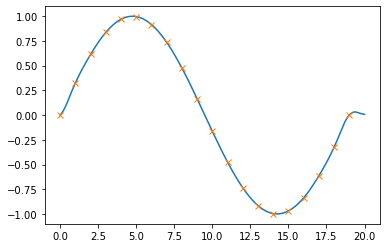

In [10]:
# Source: https://gist.github.com/jgillis/54767ae9e38dca3dfcb9144fb4eb4398

from casadi import *
import pylab as plt

# ====================================
#    Data to be interpolated
#
# =====================================


N = 20

# Generate some data to be interpolated
xs = np.array(range(N))
ys = sin(linspace(0, 2*pi, N))


# ====================================
#    Spline Basis function
#
# =====================================

# second-order B-spline Basis
x = SX.sym("x")
basis = Function('basis', [x], [if_else(
    x <= 0, x**2/2+x+0.5, if_else(x <= 1, -x**2+x+0.5, x**2/2-2*x+2))])


# ====================================
#    Spline function = sum of bases
#
# =====================================


# Spline coefficients
C = MX.sym("C", N)

# Create spline: sum of adjacent basis functions
X = MX.sym("X")

# Anchor points of adjacent bases
ffX = floor(X-0.5)
fX = floor(X+0.5)
cX = floor(X+1.5)

# This is similar to symbolic indexing, but with O(N) complexity.
# Can be replaced when implemented in CasADi
index = DM(range(N))
ffc = dot((index == ffX), C)
fc = dot((index == fX), C)
cc = dot((index == cX), C)

# Sum of adjacent bases
e = ffc*basis(X+0.5-ffX)+fc*basis(X+0.5-fX)+cc*basis(X+0.5-cX)

# Construct the spline function.
# Function of evaluation point x and coefficient list C
spline = Function('spline', [X, C], [e])

# ====================================
#    Offline fit to data
#
# =====================================


# Fitting the coefficients to the data
spline_eval_at_nodes = spline.map('eval', 'serial', N, [1], [])

err = spline_eval_at_nodes(xs, C).T - ys

solver = nlpsol('solver', 'ipopt', {"f": dot(err, err), "x": C})
Csol = solver(x0=ys)["x"]

# ====================================
#    Plot the interpolated result
#
# =====================================


Ns = 10000
ts = np.linspace(0, N, Ns)

spline_eval = spline.map('eval', 'serial', Ns, [1], [])

plt.plot(ts, spline_eval(ts, Csol).T)
plt.plot(xs, ys, 'x')
plt.show()


In [36]:
def basis_function(t):
    t_ = np.array([1, t, t**2, t**3])
    feature_matrix = 1/6* np.array([[1, 4, 1, 0],
                               [-3,0 ,3,0],
                                 [3,-6,3,0],
                                 [-1,3,-3,1]])
    
    return t_ @ feature_matrix


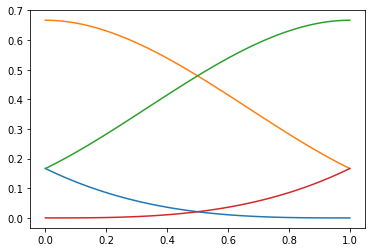

In [37]:
ts = np.linspace(0, 1, 100)
basis = np.zeros((100, 4))
for i, t in enumerate(ts):
    basis[i] = basis_function(t)

plt.plot(ts, basis[:,0], label="Basis 0")
plt.plot(ts, basis[:,1], label="Basis 1")
plt.plot(ts, basis[:,2], label="Basis 2")
plt.plot(ts, basis[:,3], label="Basis 3")


In [77]:
# vectorize the basis function
def basis_function_mat(ts, n_control_points, n_knots):
    mat = np.zeros((ts.shape[0], n_control_points))
    for i, t in enumerate(ts):
        offset = max(min(int(np.floor(t)), n_knots -1),0)
        u = t - offset
        mat[i][offset: offset + 4] = basis_function(u)
    
    return mat


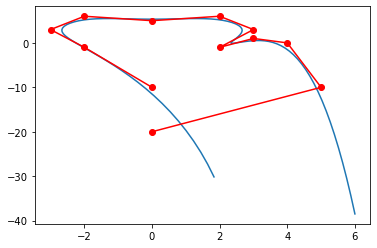

In [78]:
control_points = np.array([[0,-10], [-2,-1], [-3,3],[-2,6], [0,5], [2,6], [3,3], [2,-1], [3,1], [4,0], [5,-10], [0,-20]])
knots = [0,1,2,3,4,5,6,7]

curve = np.zeros((100, 2))
ts = np.linspace(-2, 10, 100)

basis = basis_function_mat(ts,12, 8)
curve = basis @ control_points


plt.plot(curve[:,0], curve[:,1], label="B-spline curve")
plt.plot(control_points[:,0], control_points[:,1], "ro-")


In [79]:
# Casadi Function for B-spline
def spline_eval(control_points, num_samples):
    n_knots = control_points.shape[0] - 4

    ts = np.linspace(0, n_knots, num_samples)
    basis = basis_function_mat(ts, control_points.shape[0], n_knots)
    curve = basis @ control_points

    return curve



Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      302
        inequality constraints with only lower bounds:      300
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   2.0849627798511925e+00    2.0849627798511925e+00
Dual infeasibility......:   5.1321732464720826e-04    5.1321732464720826e-04
Constraint violation....:   1.2935667173780141e-05    1.2935667173780141e-05
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

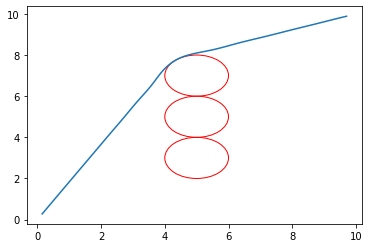

In [93]:
#B-spline basis function as casssssadi symbolic expression

# Assumptioms: Knots are equally spaced and constant for this optimization problem, They are defined in such a way that the B-spline is closed
# The control points are the decision variables


import casadi as cas

# Decision variables
n_control_points = 20
n_knots = n_control_points - 4
control_points = cas.SX.sym("control_points", n_control_points, 2)
dec_vars = cas.vertcat(cas.vec(control_points))


# Define Curve points with respect to control points and basis functions
curve = spline_eval(control_points, 100)

# Define constraints
start_point = np.array([0, 0])
end_point = np.array([10, 10])

cons = cas.SX([])
lbg = []
ubg = []

cons = cas.vertcat(cons, (curve[0,0] - start_point[0]) ** 2 + (curve[0,1] - start_point[1]) ** 2)
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0.1]))

cons = cas.vertcat(cons, (curve[-1,0] - end_point[0]) ** 2 + (curve[-1,1] - end_point[1]) ** 2)
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0.1]))

# Define Obstacle constraint
obstacle_positions = np.array([[5, 5], [5, 7], [5,3]])
obstacle_radii = np.array([1, 1,1])
for i in range(100):
    for obstacle_position, obstacle_radius in zip(obstacle_positions, obstacle_radii):
        cons = cas.vertcat(cons, (curve[i,0] - obstacle_position[0]) ** 2 + (curve[i,1] - obstacle_position[1]) ** 2 - obstacle_radius ** 2)
        lbg = np.concatenate((lbg, [0]))
        ubg = np.concatenate((ubg, [cas.inf]))

# Define cost function to minimize the length of the B-spline curve
cost = 0
for i in range(100 -1):
    cost = cost + (curve[i,0] - curve[i+1,0]) ** 2 + (curve[i,1] - curve[i+1,1]) ** 2



# Create Optimization problem
nlp = {"x": dec_vars, "f": cost, "g": cons}
ipop_options = {"ipopt.print_level": 3, "ipopt.max_iter": 1000, "ipopt.tol": 1e-3, "print_time": 0, "ipopt.acceptable_tol": 1e-3, "ipopt.acceptable_obj_change_tol": 1e-3, "ipopt.hessian_approximation": "limited-memory"}

solver = cas.nlpsol("solver", "ipopt", nlp, ipop_options)

# Solve Optimization problem
res = solver(lbg=lbg, ubg=ubg)
sol_control_points = res["x"].reshape((n_control_points, 2))

# Plot the B-spline using numpy and scipy
curve = spline_eval(sol_control_points, 100)
plt.plot(curve[:,0], curve[:,1], label="B-spline curve")
# Plot the control points
#plt.plot(sol_control_points[:,0], sol_control_points[:,1], "ro-")

# plot obstacles
for obstacle_position, obstacle_radius in zip(obstacle_positions, obstacle_radii):
    circle = plt.Circle(obstacle_position, obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(circle)

plt.show()




